# Pix2Pix 

Following code Separately store the weights each layer of generator network

## Import TensorFlow and other libraries

In [147]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
os.environ['CUDA_VISIBLE_DEVICES']=''
import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
from termcolor import colored

In [76]:
tf.__version__

'2.0.0'

In [77]:
PATH = 'dataset/'
BUFFER_SIZE = 10
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [78]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return real_image,input_image

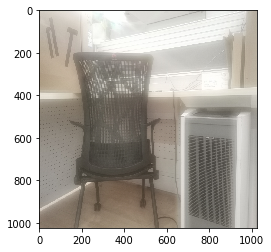

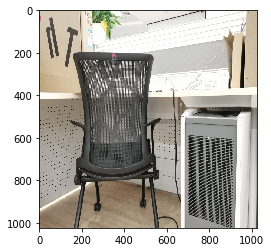

In [79]:
inp, re = load(PATH+'train/1.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [80]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [81]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [82]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [83]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

As you can see in the images below
that they are going through random jittering
Random jittering as described in the paper is to

1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally

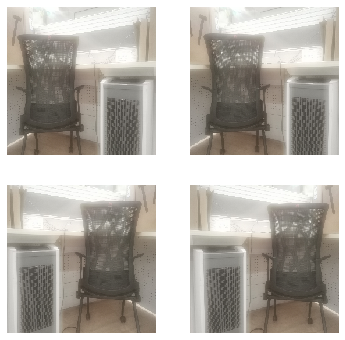

In [84]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [85]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [86]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Input Pipeline

In [87]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [88]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).



In [89]:
OUTPUT_CHANNELS = 3

In [90]:
def downsample(filters, size, apply_batchnorm=True, name='downsample'):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',name=name+'_conv',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [91]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 512, 512, 3)


In [92]:
def upsample(filters, size, apply_dropout=False, name='upsample'):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    name=name+'_transposeconv',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [93]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 1024, 1024, 3)


In [94]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False,name='downsample_1'), # (bs, 128, 128, 64)
    downsample(128, 4,name='downsample_2'), # (bs, 64, 64, 128)
    downsample(256, 4,name='downsample_3'), # (bs, 32, 32, 256)
    downsample(512, 4,name='downsample_4'), # (bs, 16, 16, 512)
    downsample(512, 4,name='downsample_5'), # (bs, 8, 8, 512)
    downsample(512, 4,name='downsample_6'), # (bs, 4, 4, 512)
    downsample(512, 4,name='downsample_7'), # (bs, 2, 2, 512)
    downsample(512, 4,name='downsample_8'), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True,name='upsample_1'), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True,name='upsample_2'), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True,name='upsample_3'), # (bs, 8, 8, 1024)
    upsample(512, 4,name='upsample_4'), # (bs, 16, 16, 1024)
    upsample(256, 4,name='upsample_5'), # (bs, 32, 32, 512)
    upsample(128, 4,name='upsample_6'), # (bs, 64, 64, 256)
    upsample(64, 4,name='upsample_7'), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh',
                                         name='upsample_8') # (bs, 256, 256, 3)

  x = inputs
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    print(colored(x.name + ' shape :: {} '.format(x.shape),'yellow', attrs=['blink']))
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print(colored(x.name + ' shape :: {} '.format(x.shape),'cyan', attrs=['blink']))
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  print(colored(x.name + ' shape :: {} '.format(x.shape),'cyan', attrs=['blink']))

  return tf.keras.Model(inputs=inputs, outputs=x)

In [95]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

sequential_131/Identity:0 shape :: (None, 128, 128, 64) 
sequential_132/Identity:0 shape :: (None, 64, 64, 128) 
sequential_133/Identity:0 shape :: (None, 32, 32, 256) 
sequential_134/Identity:0 shape :: (None, 16, 16, 512) 
sequential_135/Identity:0 shape :: (None, 8, 8, 512) 
sequential_136/Identity:0 shape :: (None, 4, 4, 512) 
sequential_137/Identity:0 shape :: (None, 2, 2, 512) 
sequential_138/Identity:0 shape :: (None, 1, 1, 512) 
sequential_139/Identity:0 shape :: (None, 2, 2, 512) 
sequential_140/Identity:0 shape :: (None, 4, 4, 512) 
sequential_141/Identity:0 shape :: (None, 8, 8, 512) 
sequential_142/Identity:0 shape :: (None, 16, 16, 512) 
sequential_143/Identity:0 shape :: (None, 32, 32, 256) 
sequential_144/Identity:0 shape :: (None, 64, 64, 128) 
sequential_145/Identity:0 shape :: (None, 128, 128, 64) 
upsample_8_7/Identity:0 shape :: (None, 256, 256, 3) 


In [96]:
print('='*50)
text = colored('Total Trainable parameters of Generator are :: {}'.format(generator.count_params()), 'red', attrs=['reverse','blink'])
print(text)
print('='*50)

Total Trainable parameters of Generator are :: 54425859


W1204 18:48:00.218671 140244570896192 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


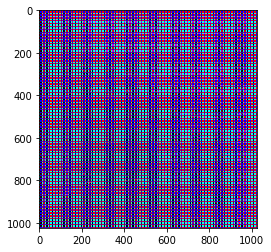

In [97]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [98]:
LAMBDA = 100

In [99]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [100]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
    
    print(colored(x.name + ' shape :: {} '.format(x.shape),'magenta', attrs=['blink']))

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    print(colored(down1.name + ' shape :: {} '.format(down1.shape),'magenta', attrs=['blink']))
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    print(colored(down2.name + ' shape :: {} '.format(down2.shape),'magenta', attrs=['blink']))
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    print(colored(down3.name + ' shape :: {} '.format(down3.shape),'magenta', attrs=['blink']))

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    print(colored(conv.name + ' shape :: {} '.format(conv.shape),'magenta', attrs=['blink']))

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    print(colored(last.name + ' shape :: {} '.format(last.shape),'magenta', attrs=['blink']))

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [101]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

concatenate_58/Identity:0 shape :: (None, 256, 256, 6) 
sequential_146/Identity:0 shape :: (None, 128, 128, 64) 
sequential_147/Identity:0 shape :: (None, 64, 64, 128) 
sequential_148/Identity:0 shape :: (None, 32, 32, 256) 
conv2d_4/Identity:0 shape :: (None, 31, 31, 512) 
conv2d_5/Identity:0 shape :: (None, 30, 30, 1) 


In [102]:
print('='*50)
text = colored('Total Trainable parameters of Discriminator are :: {}'.format(discriminator.count_params()), 'blue', attrs=['reverse','blink'])
print(text)
print('='*50)

Total Trainable parameters of Discriminator are :: 2770433


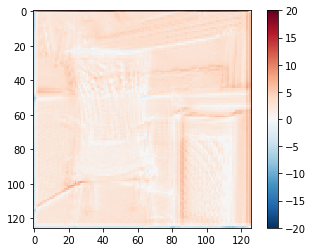

In [103]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [104]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [105]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the Optimizers and Checkpoint-saver




In [106]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [107]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [108]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

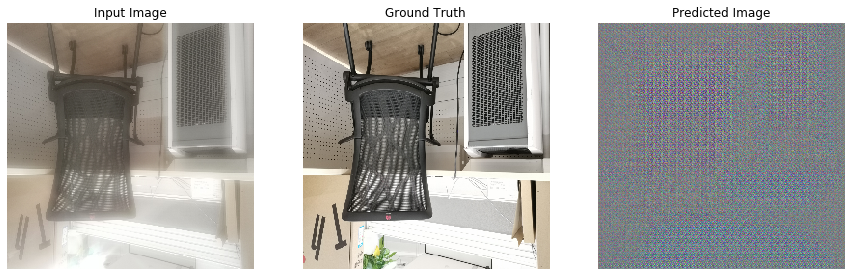

In [109]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [110]:
EPOCHS = 5

In [111]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [112]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [113]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

Now run the training loop:

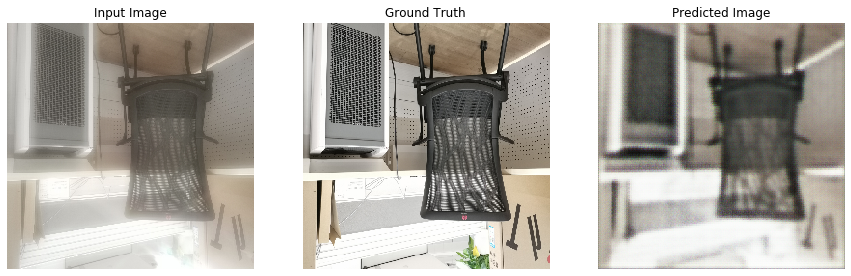

Epoch:  9
.....
Time taken for epoch 10 is 4.118179559707642 sec



In [114]:
fit(train_dataset, EPOCHS, test_dataset)

## Restore the latest checkpoint and test

In [116]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

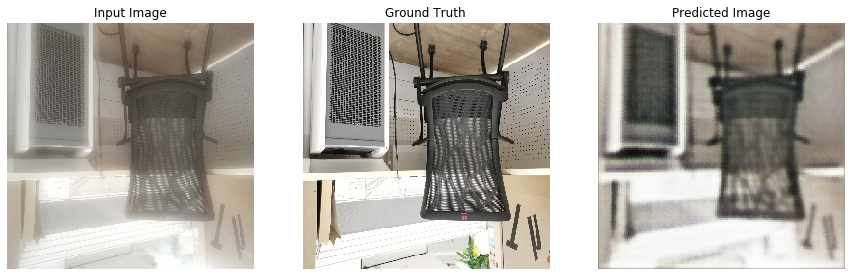

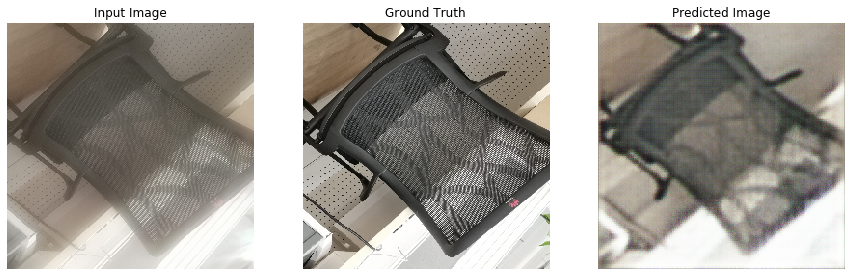

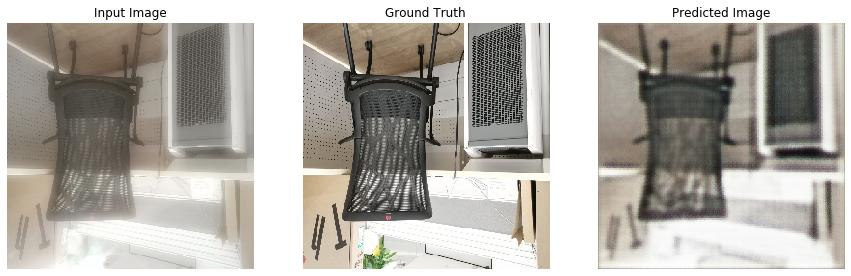

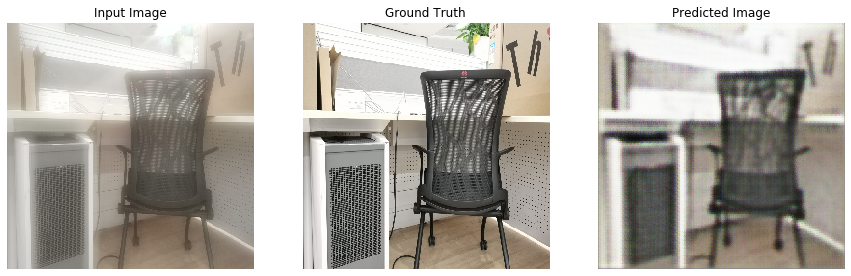

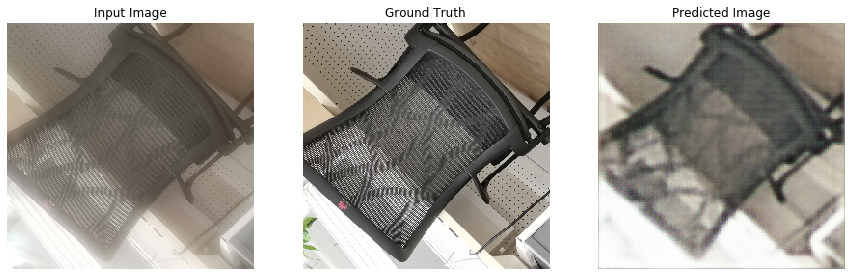

In [117]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

In [129]:
try:
    os.mkdir('Weights')
except:
    pass

model_layers = []

for layer in generator.layers:
    if 'sequential' in layer.name:
        for layer2 in layer.layers:
            if '_conv' in layer2.name:
                model_layers.append(layer2)
            elif '_transposeconv' in layer2.name:
                model_layers.append(layer2)
    elif 'upsample_8' in layer.name:
                model_layers.append(layer)
    
                

In [141]:
names = [
        'downsample_1',
        'downsample_2',
        'downsample_3',
        'downsample_4',
        'downsample_5',
        'downsample_6',
        'downsample_7',
        'downsample_8',
        'upsample_1',
        'upsample_2',
        'upsample_3',
        'upsample_4',
        'upsample_5',
        'upsample_6',
        'upsample_7',
        'upsample_8',
        ]
for name in names :
    try:
        folder = 'Weights/'+ name
        os.mkdir(folder)
    except:
        pass
    tmp1,tmp2,tmp3 = 1,1,1
    for layer in model_layers:
        if name in layer.name:
            try:
                np.save(folder+'/{}.npy'.format(layer.name),np.array(layer.get_weights(),dtype=np.float32))
            except:
                np.save(folder+'/{}_weights.npy'.format(layer.name),np.array(layer.get_weights()[0],dtype=np.float32))
                np.save(folder+'/{}_bias.npy'.format(layer.name),np.array(layer.get_weights()[1],dtype=np.float32))
                

print(colored('Saperately weights of each convolution saved successfully !!!! ','magenta', attrs=['blink']))
print('='*100)

Saperately weights of each convolution saved successfully !!!! 
